In [1]:
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)
np.seterr(all='ignore')

cars_LinearRegression = pd.read_parquet("cars_ready_LinearRegression_small.parquet")
print("Price" in cars_LinearRegression.columns)
print(cars_LinearRegression.columns.tolist())

cars_DecisionTree = pd.read_parquet("cars_ready_DecisionTree_small.parquet")
print("Price" in cars_DecisionTree.columns)
print(cars_DecisionTree.columns.tolist())

cars_BART = pd.read_parquet("cars_ready_BART.parquet")
print("Price" in cars_BART.columns)
print(cars_BART.columns.tolist())



# 🔁 Ogranicz do 1000 losowych rekordów (np. na potrzeby szybkiego testu BART)
#cars_BART = cars_BART.sample(n=1000, random_state=42).reset_index(drop=True)
#print(f"✅ Subsampled cars_BART: {cars_BART.shape}")

False
['Mileage', 'Log_Mileage', 'Age', 'Log_Age', 'Mileage_per_Year', 'Engine_Power', 'Engine_Capacity', 'Power_per_Liter', 'No_Accidents', 'Service_Record', 'Is_Imported', 'First_Owner', 'Professional_Seller', 'Make_Aixam', 'Make_Alfa Romeo', 'Make_Audi', 'Make_Baic', 'Make_Bentley', 'Make_Bmw', 'Make_Cadillac', 'Make_Chevrolet', 'Make_Chrysler', 'Make_Citroën', 'Make_Cupra', 'Make_Dacia', 'Make_Daihatsu', 'Make_Dodge', 'Make_Ds Automobiles', 'Make_Fiat', 'Make_Ford', 'Make_Honda', 'Make_Hyundai', 'Make_Infiniti', 'Make_Isuzu', 'Make_Iveco', 'Make_Jaecoo', 'Make_Jaguar', 'Make_Jeep', 'Make_Kia', 'Make_Lamborghini', 'Make_Lancia', 'Make_Land Rover', 'Make_Lexus', 'Make_Maserati', 'Make_Mazda', 'Make_Mercedes-Benz', 'Make_Mg', 'Make_Mini', 'Make_Mitsubishi', 'Make_Nissan', 'Make_Opel', 'Make_Peugeot', 'Make_Porsche', 'Make_Ram', 'Make_Renault', 'Make_Saab', 'Make_Seat', 'Make_Skoda', 'Make_Smart', 'Make_Ssangyong/Kgm', 'Make_Subaru', 'Make_Suzuki', 'Make_Tesla', 'Make_Toyota', 'Make_Vo

In [2]:
import os
from datasets import Dataset, DatasetDict, load_from_disk
from transformers import AutoTokenizer

# Ścieżka do zapisanego datasetu
dataset_path = "bart_regression_dataset"

if os.path.exists(dataset_path):
    print("📂 Found existing dataset. Loading from disk...")
    dataset = load_from_disk(dataset_path)
else:
    print("🔄 Tokenizing and saving dataset...")

    # Załaduj dane
    df = cars_BART[['Textual_Input', 'Log_Price', 'cv_fold']].dropna().copy()

    # Podziel dane na trening i test
    train_df = df[df['cv_fold'] != -1].reset_index(drop=True)
    test_df = df[df['cv_fold'] == -1].reset_index(drop=True)

    # Tokenizer (np. dla PolBARTa)
    tokenizer = AutoTokenizer.from_pretrained("allegro/herbert-base-cased")

    # Funkcja do tokenizacji
    def tokenize(example):
        tokens = tokenizer(example['Textual_Input'], truncation=True, padding='max_length', max_length=128)
        tokens['labels'] = example['Log_Price']
        return tokens

    # Stwórz dataset
    train_dataset = Dataset.from_pandas(train_df)
    test_dataset = Dataset.from_pandas(test_df)

    tokenized_train = train_dataset.map(tokenize, batched=False)
    tokenized_test = test_dataset.map(tokenize, batched=False)

    dataset = DatasetDict({
        "train": tokenized_train,
        "test": tokenized_test
    })

    # Zapisz ztokenizowany zbiór danych
    dataset.save_to_disk(dataset_path)
    print("✅ Tokenized dataset saved to 'bart_regression_dataset'")

/Users/igorhebda/Desktop/PJA-dyplom/Data_collection_phase/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🔄 Tokenizing and saving dataset...


Saving the dataset (1/1 shards): 100%|██████████| 41309/41309 [00:00<00:00, 870324.72 examples/s]

✅ Tokenized dataset saved to 'bart_regression_dataset'


In [3]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import torch

# Model bazowy (np. HerBERT)
model_name = "allegro/herbert-base-cased"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=1, problem_type="regression")

# Użycie GPU (jeśli dostępne)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)

# Funkcja do obliczania metryk (sklearn offline)
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = predictions.squeeze()
    mae = mean_absolute_error(labels, predictions)
    rmse = np.sqrt(mean_squared_error(labels, predictions))
    return {"mae": mae, "rmse": rmse}

# Argumenty treningowe
training_args = TrainingArguments(
    output_dir="./bart_regression_output",
    eval_strategy="epoch",
    save_strategy="epoch",             # <---- zmienione
    save_steps=1000,                   # <---- zapisuj co 1000 kroków
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./bart_logs",
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="rmse",
    greater_is_better=False,
    save_total_limit=1,
    save_safetensors=True
)

# Trener
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    compute_metrics=compute_metrics
)

# Start treningu
trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allegro/herbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/igorhebda/Desktop/PJA-dyplom/Data_collection_phase/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/igorhebda/Desktop/PJA-dyplom/Data_collection_phase/.venv/lib/python3.13/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Mae,Rmse
1,0.079300,0.054600,0.171093,0.233665
2,0.064800,0.059237,0.183114,0.243386
3,0.056700,0.058980,0.185361,0.242859
4,0.054700,0.052490,0.172417,0.229106
5,0.057100,0.051487,0.169463,0.226907


/Users/igorhebda/Desktop/PJA-dyplom/Data_collection_phase/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/igorhebda/Desktop/PJA-dyplom/Data_collection_phase/.venv/lib/python3.13/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/Users/igorhebda/Desktop/PJA-dyplom/Data_collection_phase/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/igorhebda/Desktop/PJA-dyplom/Data_collection_phase/.venv/lib/python3.13/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_atte

TrainOutput(global_step=51640, training_loss=0.11544445946547156, metrics={'train_runtime': 16489.2394, 'train_samples_per_second': 50.104, 'train_steps_per_second': 3.132, 'total_flos': 5.434378499403264e+16, 'train_loss': 0.11544445946547156, 'epoch': 5.0})

/Users/igorhebda/Desktop/PJA-dyplom/Data_collection_phase/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/igorhebda/Desktop/PJA-dyplom/Data_collection_phase/.venv/lib/python3.13/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


📊 Test set performance:
MAE:  0.1695
RMSE: 0.2269
R²:   0.9401


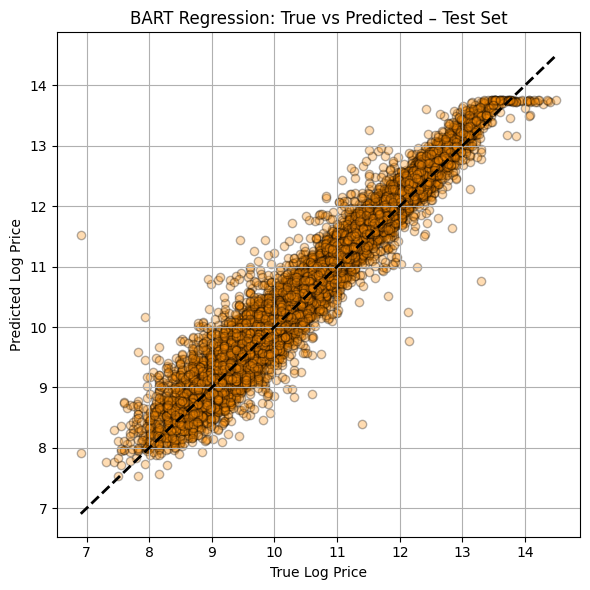

In [4]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Upewnij się, że jesteś na właściwym urządzeniu
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)
model.eval()

# Pobierz predykcje
raw_preds = trainer.predict(dataset["test"])
y_pred = raw_preds.predictions.squeeze()
y_true = raw_preds.label_ids

# Oblicz metryki
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print("📊 Test set performance:")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")

# Wykres True vs Predicted
plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, alpha=0.3, color="darkorange", edgecolor="k")
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'k--', lw=2)
plt.xlabel("True Log Price")
plt.ylabel("Predicted Log Price")
plt.title("BART Regression: True vs Predicted – Test Set")
plt.grid(True)
plt.tight_layout()
plt.show()

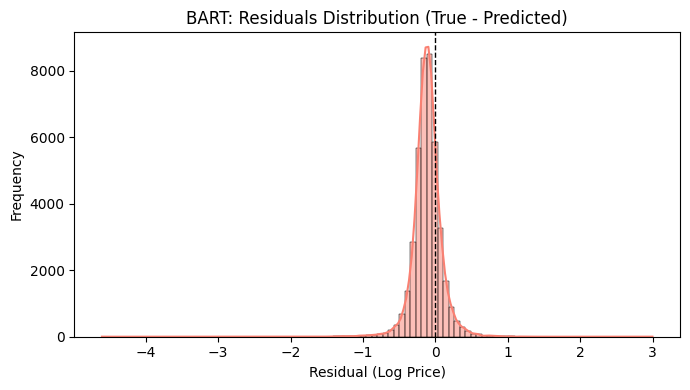

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Oblicz reszty
residuals = y_true - y_pred

# Histogram z gęstością
plt.figure(figsize=(7, 4))
sns.histplot(residuals, bins=100, color='salmon', edgecolor='black', kde=True)
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)

plt.title("BART: Residuals Distribution (True - Predicted)")
plt.xlabel("Residual (Log Price)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

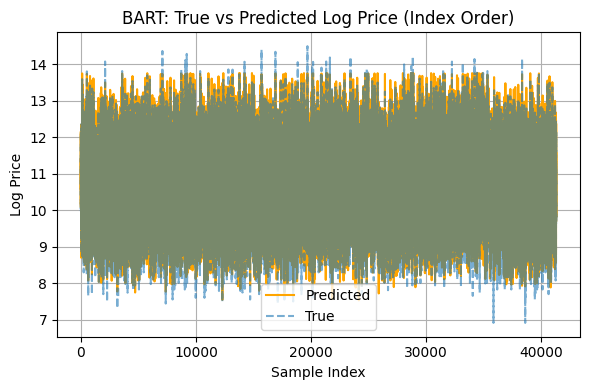

In [6]:
plt.figure(figsize=(6, 4))
plt.plot(y_pred, label="Predicted", color="orange")
plt.plot(y_true, label="True", alpha=0.6, linestyle="--")
plt.title("BART: True vs Predicted Log Price (Index Order)")
plt.xlabel("Sample Index")
plt.ylabel("Log Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

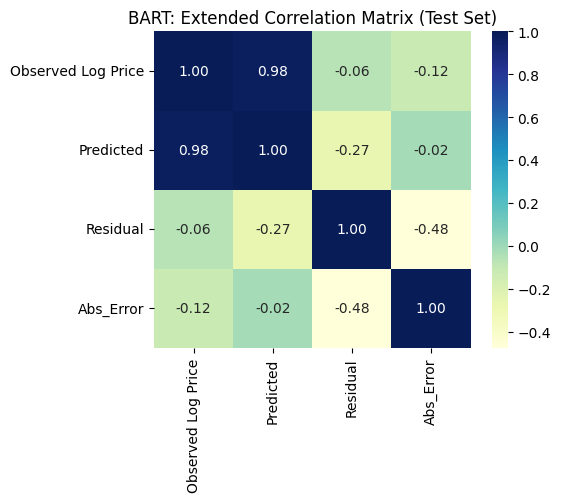

In [7]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Przygotuj DataFrame
df_eval = pd.DataFrame({
    "Observed Log Price": y_true,
    "Predicted": y_pred,
})
df_eval["Residual"] = df_eval["Observed Log Price"] - df_eval["Predicted"]
df_eval["Abs_Error"] = np.abs(df_eval["Residual"])

# Macierz korelacji
corr_matrix = df_eval.corr()

# Wizualizacja
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="YlGnBu", square=True, cbar=True)
plt.title("BART: Extended Correlation Matrix (Test Set)")
plt.tight_layout()
plt.show()

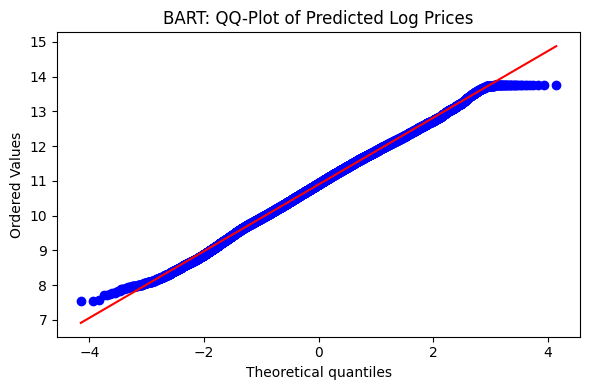

In [8]:
import scipy.stats as stats

plt.figure(figsize=(6, 4))
stats.probplot(y_pred, dist="norm", plot=plt)
plt.title("BART: QQ-Plot of Predicted Log Prices")
plt.tight_layout()
plt.show()